## Influence of hyper-paramters 

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import os
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from common import VGGStyleCNN, load_data
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

In [45]:
def train_model(train_data, directory, num_epochs=10, learning_rate=0.001, dropout_rate=0.5, weight_decay=0, batch_size=128):
    train_accuracy = []
    train_loss = []
    
    
    device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
    model = VGGStyleCNN(dropout_rate=dropout_rate).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_tqdm = tqdm(train_data, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loader_tqdm.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_data)
        accuracy = 100 * correct / total

        train_accuracy.append(accuracy)
        train_loss.append(avg_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Save the model
    model_save_path = f'models/{directory}/lr_{learning_rate}_dropout_{dropout_rate}_wd_{weight_decay}_bs_{batch_size}'
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # Create directory if it doesn't exist
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved at: {model_save_path} \n")
    
    return {
        'model': model,
        'accuracy': train_accuracy,
        'loss': train_loss,
    }

In [31]:
def test_model(test_data , model=None, model_path=''):
    device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
    
    if model_path:
        torch.load(model_path, map_location=torch.device('xpu'))
        model.load_state_dict(torch.load(model_path))
    
    model.eval()
    
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_data:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy on validation set: {accuracy:.2f}%")

    # Calculate additional metrics
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'conf_matrix': conf_matrix
    }

### Training process

#### Learning rate

In [37]:
# loading the data
loaded_data = load_data()  # default batch_size = 128
train_data, test_data = loaded_data['train'], loaded_data['test']

In [38]:
# Training models
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
models_lr = []


for lr in learning_rates:
    print(f'------Training model with learning_rate: {lr}-------')
    train_results = train_model(train_data, directory='lr', num_epochs=10, learning_rate=lr)
    models_lr.append(train_results)

------Training model with learning_rate: 1e-05-------


Epoch 1/10: 100%|██████████| 704/704 [02:48<00:00,  4.18it/s, loss=1.69]


Epoch [1/10], Loss: 1.7452, Accuracy: 34.46%


Epoch 2/10: 100%|██████████| 704/704 [02:48<00:00,  4.18it/s, loss=1.37]


Epoch [2/10], Loss: 1.4202, Accuracy: 47.46%


Epoch 3/10: 100%|██████████| 704/704 [02:51<00:00,  4.11it/s, loss=1.7]  


Epoch [3/10], Loss: 1.2623, Accuracy: 53.80%


Epoch 4/10: 100%|██████████| 704/704 [02:49<00:00,  4.16it/s, loss=1.08] 


Epoch [4/10], Loss: 1.1311, Accuracy: 58.98%


Epoch 5/10: 100%|██████████| 704/704 [02:48<00:00,  4.17it/s, loss=1.2]  


Epoch [5/10], Loss: 0.9953, Accuracy: 64.02%


Epoch 6/10: 100%|██████████| 704/704 [02:48<00:00,  4.17it/s, loss=1.51] 


Epoch [6/10], Loss: 0.8452, Accuracy: 69.80%


Epoch 7/10: 100%|██████████| 704/704 [02:55<00:00,  4.02it/s, loss=0.574]


Epoch [7/10], Loss: 0.6731, Accuracy: 76.29%


Epoch 8/10: 100%|██████████| 704/704 [02:57<00:00,  3.97it/s, loss=0.365]


Epoch [8/10], Loss: 0.4961, Accuracy: 82.82%


Epoch 9/10: 100%|██████████| 704/704 [02:58<00:00,  3.94it/s, loss=0.594]


Epoch [9/10], Loss: 0.3425, Accuracy: 88.42%


Epoch 10/10: 100%|██████████| 704/704 [02:55<00:00,  4.00it/s, loss=0.625]


Epoch [10/10], Loss: 0.2192, Accuracy: 92.84%
Model saved at: models/lr/lr_1e-05_dropout_0.5_wd_0_bs_128 

------Training model with learning_rate: 0.0001-------


Epoch 1/10: 100%|██████████| 704/704 [02:54<00:00,  4.03it/s, loss=1.53] 


Epoch [1/10], Loss: 1.4344, Accuracy: 47.23%


Epoch 2/10: 100%|██████████| 704/704 [02:56<00:00,  3.98it/s, loss=1.73] 


Epoch [2/10], Loss: 1.0867, Accuracy: 60.91%


Epoch 3/10: 100%|██████████| 704/704 [02:56<00:00,  4.00it/s, loss=1.06] 


Epoch [3/10], Loss: 0.9033, Accuracy: 67.84%


Epoch 4/10: 100%|██████████| 704/704 [02:55<00:00,  4.01it/s, loss=0.583]


Epoch [4/10], Loss: 0.7537, Accuracy: 73.09%


Epoch 5/10: 100%|██████████| 704/704 [02:56<00:00,  3.99it/s, loss=0.653]


Epoch [5/10], Loss: 0.6071, Accuracy: 78.21%


Epoch 6/10: 100%|██████████| 704/704 [02:40<00:00,  4.39it/s, loss=0.4]  


Epoch [6/10], Loss: 0.4680, Accuracy: 83.22%


Epoch 7/10: 100%|██████████| 704/704 [02:23<00:00,  4.89it/s, loss=0.605]


Epoch [7/10], Loss: 0.3485, Accuracy: 87.75%


Epoch 8/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=0.171]


Epoch [8/10], Loss: 0.2595, Accuracy: 90.90%


Epoch 9/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=0.0443]


Epoch [9/10], Loss: 0.1956, Accuracy: 93.23%


Epoch 10/10: 100%|██████████| 704/704 [02:25<00:00,  4.84it/s, loss=0.0728]


Epoch [10/10], Loss: 0.1571, Accuracy: 94.54%
Model saved at: models/lr/lr_0.0001_dropout_0.5_wd_0_bs_128 

------Training model with learning_rate: 0.001-------


Epoch 1/10: 100%|██████████| 704/704 [02:24<00:00,  4.89it/s, loss=1.38]


Epoch [1/10], Loss: 1.6370, Accuracy: 39.32%


Epoch 2/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=1.64] 


Epoch [2/10], Loss: 1.2947, Accuracy: 54.20%


Epoch 3/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=1.22] 


Epoch [3/10], Loss: 1.1227, Accuracy: 60.86%


Epoch 4/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=0.623]


Epoch [4/10], Loss: 1.0006, Accuracy: 65.76%


Epoch 5/10: 100%|██████████| 704/704 [02:23<00:00,  4.91it/s, loss=0.42] 


Epoch [5/10], Loss: 0.9929, Accuracy: 66.65%


Epoch 6/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=1.57] 


Epoch [6/10], Loss: 0.8114, Accuracy: 72.21%


Epoch 7/10: 100%|██████████| 704/704 [02:24<00:00,  4.86it/s, loss=0.567]


Epoch [7/10], Loss: 0.7840, Accuracy: 73.28%


Epoch 8/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=2.35] 


Epoch [8/10], Loss: 0.6804, Accuracy: 76.61%


Epoch 9/10: 100%|██████████| 704/704 [02:24<00:00,  4.86it/s, loss=0.802]


Epoch [9/10], Loss: 0.6175, Accuracy: 79.02%


Epoch 10/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=1.96] 


Epoch [10/10], Loss: 0.5501, Accuracy: 81.10%
Model saved at: models/lr/lr_0.001_dropout_0.5_wd_0_bs_128 

------Training model with learning_rate: 0.01-------


Epoch 1/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=2.3] 


Epoch [1/10], Loss: 4.9353, Accuracy: 9.95%


Epoch 2/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=2.31]


Epoch [2/10], Loss: 2.3366, Accuracy: 10.06%


Epoch 3/10: 100%|██████████| 704/704 [02:25<00:00,  4.84it/s, loss=2.31]


Epoch [3/10], Loss: 2.3283, Accuracy: 9.77%


Epoch 4/10: 100%|██████████| 704/704 [02:25<00:00,  4.83it/s, loss=2.3] 


Epoch [4/10], Loss: 2.3296, Accuracy: 10.00%


Epoch 5/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=2.31]


Epoch [5/10], Loss: 2.3317, Accuracy: 9.89%


Epoch 6/10: 100%|██████████| 704/704 [02:26<00:00,  4.80it/s, loss=2.3] 


Epoch [6/10], Loss: 2.3091, Accuracy: 9.96%


Epoch 7/10: 100%|██████████| 704/704 [02:24<00:00,  4.89it/s, loss=2.3] 


Epoch [7/10], Loss: 2.3336, Accuracy: 9.99%


Epoch 8/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=2.31]


Epoch [8/10], Loss: 2.3059, Accuracy: 9.91%


Epoch 9/10: 100%|██████████| 704/704 [02:22<00:00,  4.93it/s, loss=2.29]


Epoch [9/10], Loss: 2.3167, Accuracy: 10.07%


Epoch 10/10: 100%|██████████| 704/704 [02:22<00:00,  4.92it/s, loss=2.3] 


Epoch [10/10], Loss: 2.3062, Accuracy: 9.92%
Model saved at: models/lr/lr_0.01_dropout_0.5_wd_0_bs_128 

------Training model with learning_rate: 0.1-------


Epoch 1/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=2.34]  


Epoch [1/10], Loss: 1813.3239, Accuracy: 9.83%


Epoch 2/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=2.35]


Epoch [2/10], Loss: 2.3084, Accuracy: 9.82%


Epoch 3/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=2.29]


Epoch [3/10], Loss: 2.3088, Accuracy: 9.88%


Epoch 4/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=2.3] 


Epoch [4/10], Loss: 2.3088, Accuracy: 9.90%


Epoch 5/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=2.28]


Epoch [5/10], Loss: 2.3092, Accuracy: 9.72%


Epoch 6/10: 100%|██████████| 704/704 [02:23<00:00,  4.91it/s, loss=2.35]


Epoch [6/10], Loss: 2.3087, Accuracy: 10.08%


Epoch 7/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=2.32]


Epoch [7/10], Loss: 2.3086, Accuracy: 9.83%


Epoch 8/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=2.31]


Epoch [8/10], Loss: 2.3088, Accuracy: 10.01%


Epoch 9/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=2.3] 


Epoch [9/10], Loss: 2.3163, Accuracy: 9.99%


Epoch 10/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=2.3] 


Epoch [10/10], Loss: 2.3088, Accuracy: 10.06%
Model saved at: models/lr/lr_0.1_dropout_0.5_wd_0_bs_128 



In [40]:
tests_lr = []
for train_results, lr in zip(models_lr, learning_rates):
    print(f"-----Results for learning rate: {lr}-----")
    test_results = test_model(test_data, train_results['model'])
    tests_lr.append(test_results)
    pprint(test_results)
    print()

-----Results for learning rate: 1e-05-----
Accuracy on validation set: 53.44%
{'accuracy': 53.43555555555555,
 'conf_matrix': array([[5990,  441,  582,  161,  193,  164,   96,  162,  915,  296],
       [ 310, 6042,   92,  143,  129,  188,  106,  201,  398, 1391],
       [ 559,  140, 4131,  940,  972,  719,  857,  270,  340,   72],
       [ 121,  157,  763, 3604, 1233, 1524,  909,  404,  204,   81],
       [ 210,  118,  936,  947, 4127,  804,  439, 1126,  216,   77],
       [ 122,  187,  785, 1880, 1423, 3016,  390,  879,  219,   99],
       [  50,   98,  750, 1058,  562,  355, 5907,   70,  118,   32],
       [ 171,  155,  341,  416, 1295,  844,   85, 5372,  145,  176],
       [1023,  712,  376,  304,  273,  241,  171,  178, 5222,  500],
       [ 394, 2229,  102,  233,  187,  251,   89,  341,  493, 4681]]),
 'f1': 0.5347587663123766,
 'precision': 0.5377690378257005,
 'recall': 0.5343555555555556}

-----Results for learning rate: 0.0001-----
Accuracy on validation set: 68.37%
{'accuracy

c:\Users\zp13279\.conda\envs\pytorch-intel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy on validation set: 10.01%
{'accuracy': 10.006666666666666,
 'conf_matrix': array([[   4,    0,    0,    0,    0,    0,    0, 8961,   35,    0],
       [   1,    0,    0,    0,    0,    0,    0, 8997,    2,    0],
       [   1,    0,    0,    0,    0,    0,    0, 8972,   27,    0],
       [   0,    0,    0,    0,    0,    0,    0, 8992,    8,    0],
       [   0,    0,    0,    0,    0,    0,    0, 8999,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0, 8986,   14,    0],
       [   0,    0,    0,    0,    0,    0,    0, 8978,   22,    0],
       [   0,    0,    0,    0,    0,    0,    0, 8998,    2,    0],
       [   0,    0,    0,    0,    0,    0,    0, 8996,    4,    0],
       [   1,    0,    0,    0,    0,    0,    0, 8997,    2,    0]]),
 'f1': 0.01837714242648527,
 'precision': 0.0705732320601696,
 'recall': 0.10006666666666666}



c:\Users\zp13279\.conda\envs\pytorch-intel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Batch size

In [43]:
batch_sizes = [16, 32, 64, 128, 256]
models_bs = []
test_data_bs = []

In [46]:
for bs in batch_sizes:
    loaded_data = load_data(batch_size=bs)
    train_data, test_data = loaded_data['train'], loaded_data['test']
    test_data_bs.append(test_data)

    print(f'------Training model with batch size: {bs}-------')
    train_results = train_model(train_data, directory='bs', num_epochs=10, batch_size=bs)
    models_bs.append(train_results)
    

------Training model with batch size: 16-------


Epoch 1/10: 100%|██████████| 5625/5625 [05:57<00:00, 15.74it/s, loss=1.84]


Epoch [1/10], Loss: 1.9999, Accuracy: 25.70%


Epoch 2/10: 100%|██████████| 5625/5625 [05:55<00:00, 15.84it/s, loss=1.55] 


Epoch [2/10], Loss: 1.6911, Accuracy: 36.74%


Epoch 3/10: 100%|██████████| 5625/5625 [05:54<00:00, 15.85it/s, loss=0.672]


Epoch [3/10], Loss: 1.4421, Accuracy: 46.76%


Epoch 4/10: 100%|██████████| 5625/5625 [05:55<00:00, 15.83it/s, loss=1.17] 


Epoch [4/10], Loss: 1.3045, Accuracy: 52.81%


Epoch 5/10: 100%|██████████| 5625/5625 [05:58<00:00, 15.70it/s, loss=1.28] 


Epoch [5/10], Loss: 1.2277, Accuracy: 56.12%


Epoch 6/10: 100%|██████████| 5625/5625 [05:56<00:00, 15.76it/s, loss=1.52] 


Epoch [6/10], Loss: 1.1443, Accuracy: 59.45%


Epoch 7/10: 100%|██████████| 5625/5625 [05:55<00:00, 15.83it/s, loss=1.23] 


Epoch [7/10], Loss: 1.0885, Accuracy: 61.66%


Epoch 8/10: 100%|██████████| 5625/5625 [05:56<00:00, 15.80it/s, loss=0.923]


Epoch [8/10], Loss: 1.0306, Accuracy: 63.90%


Epoch 9/10: 100%|██████████| 5625/5625 [05:57<00:00, 15.75it/s, loss=0.932]


Epoch [9/10], Loss: 0.9783, Accuracy: 66.12%


Epoch 10/10: 100%|██████████| 5625/5625 [05:57<00:00, 15.76it/s, loss=1.12] 


Epoch [10/10], Loss: 0.9427, Accuracy: 67.45%
Model saved at: models/bs/lr_0.001_dropout_0.5_wd_0_bs_16 

------Training model with batch size: 32-------


Epoch 1/10: 100%|██████████| 2813/2813 [04:00<00:00, 11.69it/s, loss=1.37]


Epoch [1/10], Loss: 1.7995, Accuracy: 33.59%


Epoch 2/10: 100%|██████████| 2813/2813 [03:58<00:00, 11.82it/s, loss=1.71] 


Epoch [2/10], Loss: 1.4719, Accuracy: 46.00%


Epoch 3/10: 100%|██████████| 2813/2813 [03:56<00:00, 11.88it/s, loss=1.32] 


Epoch [3/10], Loss: 1.3725, Accuracy: 50.93%


Epoch 4/10: 100%|██████████| 2813/2813 [03:56<00:00, 11.92it/s, loss=0.776]


Epoch [4/10], Loss: 1.2366, Accuracy: 56.01%


Epoch 5/10: 100%|██████████| 2813/2813 [03:56<00:00, 11.89it/s, loss=0.964]


Epoch [5/10], Loss: 1.1740, Accuracy: 58.31%


Epoch 6/10: 100%|██████████| 2813/2813 [03:56<00:00, 11.92it/s, loss=0.576]


Epoch [6/10], Loss: 1.0296, Accuracy: 63.83%


Epoch 7/10: 100%|██████████| 2813/2813 [03:56<00:00, 11.90it/s, loss=1.19] 


Epoch [7/10], Loss: 0.9473, Accuracy: 66.83%


Epoch 8/10: 100%|██████████| 2813/2813 [03:55<00:00, 11.92it/s, loss=1.36] 


Epoch [8/10], Loss: 0.8761, Accuracy: 69.34%


Epoch 9/10: 100%|██████████| 2813/2813 [03:55<00:00, 11.94it/s, loss=1.01] 


Epoch [9/10], Loss: 0.8083, Accuracy: 72.04%


Epoch 10/10: 100%|██████████| 2813/2813 [03:54<00:00, 11.98it/s, loss=0.656]


Epoch [10/10], Loss: 0.7404, Accuracy: 74.25%
Model saved at: models/bs/lr_0.001_dropout_0.5_wd_0_bs_32 

------Training model with batch size: 64-------


Epoch 1/10: 100%|██████████| 1407/1407 [02:57<00:00,  7.91it/s, loss=1.15]


Epoch [1/10], Loss: 1.6934, Accuracy: 37.51%


Epoch 2/10: 100%|██████████| 1407/1407 [02:56<00:00,  7.98it/s, loss=1.76] 


Epoch [2/10], Loss: 1.3701, Accuracy: 50.62%


Epoch 3/10: 100%|██████████| 1407/1407 [02:55<00:00,  8.00it/s, loss=0.72] 


Epoch [3/10], Loss: 1.2102, Accuracy: 57.56%


Epoch 4/10: 100%|██████████| 1407/1407 [02:56<00:00,  7.96it/s, loss=1.26] 


Epoch [4/10], Loss: 1.0897, Accuracy: 62.03%


Epoch 5/10: 100%|██████████| 1407/1407 [02:55<00:00,  8.03it/s, loss=0.52] 


Epoch [5/10], Loss: 0.9445, Accuracy: 67.22%


Epoch 6/10: 100%|██████████| 1407/1407 [02:55<00:00,  8.01it/s, loss=0.504]


Epoch [6/10], Loss: 0.8355, Accuracy: 70.87%


Epoch 7/10: 100%|██████████| 1407/1407 [02:55<00:00,  8.02it/s, loss=0.731]


Epoch [7/10], Loss: 0.7988, Accuracy: 72.58%


Epoch 8/10: 100%|██████████| 1407/1407 [02:56<00:00,  7.97it/s, loss=1.7]  


Epoch [8/10], Loss: 0.7039, Accuracy: 75.77%


Epoch 9/10: 100%|██████████| 1407/1407 [02:56<00:00,  7.99it/s, loss=0.386]


Epoch [9/10], Loss: 0.6161, Accuracy: 78.76%


Epoch 10/10: 100%|██████████| 1407/1407 [02:56<00:00,  7.96it/s, loss=0.397]


Epoch [10/10], Loss: 0.5537, Accuracy: 80.89%
Model saved at: models/bs/lr_0.001_dropout_0.5_wd_0_bs_64 

------Training model with batch size: 128-------


Epoch 1/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=2.14]


Epoch [1/10], Loss: 1.6376, Accuracy: 39.70%


Epoch 2/10: 100%|██████████| 704/704 [02:25<00:00,  4.84it/s, loss=1.63] 


Epoch [2/10], Loss: 1.2817, Accuracy: 54.56%


Epoch 3/10: 100%|██████████| 704/704 [02:24<00:00,  4.86it/s, loss=4.36] 


Epoch [3/10], Loss: 1.1031, Accuracy: 61.89%


Epoch 4/10: 100%|██████████| 704/704 [02:24<00:00,  4.86it/s, loss=0.99] 


Epoch [4/10], Loss: 1.0586, Accuracy: 63.82%


Epoch 5/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=1.28] 


Epoch [5/10], Loss: 0.9082, Accuracy: 69.17%


Epoch 6/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=0.855]


Epoch [6/10], Loss: 0.9142, Accuracy: 69.20%


Epoch 7/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=0.904]


Epoch [7/10], Loss: 0.7519, Accuracy: 74.16%


Epoch 8/10: 100%|██████████| 704/704 [02:25<00:00,  4.84it/s, loss=0.473]


Epoch [8/10], Loss: 0.6477, Accuracy: 77.64%


Epoch 9/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=0.853]


Epoch [9/10], Loss: 0.6094, Accuracy: 79.17%


Epoch 10/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=0.24] 


Epoch [10/10], Loss: 0.5148, Accuracy: 82.22%
Model saved at: models/bs/lr_0.001_dropout_0.5_wd_0_bs_128 

------Training model with batch size: 256-------


Epoch 1/10: 100%|██████████| 352/352 [02:16<00:00,  2.59it/s, loss=1.43]


Epoch [1/10], Loss: 1.6464, Accuracy: 39.41%


Epoch 2/10: 100%|██████████| 352/352 [02:12<00:00,  2.66it/s, loss=1.16]


Epoch [2/10], Loss: 1.2602, Accuracy: 54.63%


Epoch 3/10: 100%|██████████| 352/352 [02:11<00:00,  2.67it/s, loss=0.965]


Epoch [3/10], Loss: 1.0750, Accuracy: 62.19%


Epoch 4/10: 100%|██████████| 352/352 [02:13<00:00,  2.63it/s, loss=0.89] 


Epoch [4/10], Loss: 0.9405, Accuracy: 67.33%


Epoch 5/10: 100%|██████████| 352/352 [02:11<00:00,  2.67it/s, loss=0.917]


Epoch [5/10], Loss: 0.8278, Accuracy: 71.43%


Epoch 6/10: 100%|██████████| 352/352 [02:11<00:00,  2.67it/s, loss=0.666]


Epoch [6/10], Loss: 0.7276, Accuracy: 74.91%


Epoch 7/10: 100%|██████████| 352/352 [02:12<00:00,  2.67it/s, loss=0.713]


Epoch [7/10], Loss: 0.6427, Accuracy: 77.85%


Epoch 8/10: 100%|██████████| 352/352 [02:12<00:00,  2.66it/s, loss=0.481]


Epoch [8/10], Loss: 0.5525, Accuracy: 80.73%


Epoch 9/10: 100%|██████████| 352/352 [02:12<00:00,  2.66it/s, loss=0.437]


Epoch [9/10], Loss: 0.5195, Accuracy: 82.30%


Epoch 10/10: 100%|██████████| 352/352 [02:12<00:00,  2.66it/s, loss=1.66] 

Epoch [10/10], Loss: 0.8709, Accuracy: 73.41%
Model saved at: models/bs/lr_0.001_dropout_0.5_wd_0_bs_256 



In [47]:
tests_bs = []
for train_results, bs, test_data in zip(models_bs, batch_sizes, test_data_bs):
    print(f"-----Results for batch size: {bs}-----")
    test_results = test_model(test_data, train_results['model'])
    tests_bs.append(test_results)
    pprint(test_results)
    print()

-----Results for batch size: 16-----
Accuracy on validation set: 64.05%
{'accuracy': 64.04888888888888,
 'conf_matrix': array([[7188,   83,  822,   46,   19,   26,   21,   95,  539,  161],
       [ 674, 6147,   77,   58,   13,   29,   62,   81,  294, 1565],
       [ 717,   21, 6117,  477,  353,  226,  721,  130,  207,   31],
       [ 158,   35,  986, 4959,  536,  983,  870,  187,  175,  111],
       [ 467,   12, 1353,  706, 4376,  363,  396, 1105,  164,   58],
       [ 290,   39, 1100, 2074,  947, 3172,  326,  805,  130,  117],
       [ 412,   26,  987,  666,   82,   61, 6641,   12,   97,   16],
       [ 541,   22,  418,  268,  603,  490,   45, 6356,  100,  157],
       [1245,  201,  528,  141,   30,   39,  107,   81, 6167,  461],
       [ 516, 1189,  108,   73,   35,   28,   44,  141,  345, 6521]]),
 'f1': 0.6372113045388966,
 'precision': 0.6489353329443136,
 'recall': 0.6404888888888889}

-----Results for batch size: 32-----
Accuracy on validation set: 69.39%
{'accuracy': 69.3866666

### Regularization process

#### Drop out rate

In [48]:
loaded_data = load_data()
train_data, test_data = loaded_data['train'], loaded_data['test']

In [49]:
drop_out_rates = [0.1, 0.2, 0.3, 0.5]
models_dr = []

for dr in drop_out_rates:
    print(f'------Training model with drop out rate: {dr}-------')
    train_results = train_model(train_data, directory='dr', num_epochs=10, dropout_rate=dr)
    models_dr.append(train_results)

------Training model with drop out rate: 0.1-------


Epoch 1/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.15]


Epoch [1/10], Loss: 1.5661, Accuracy: 41.87%


Epoch 2/10: 100%|██████████| 704/704 [02:25<00:00,  4.85it/s, loss=1.08] 


Epoch [2/10], Loss: 1.1774, Accuracy: 57.53%


Epoch 3/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=1.26] 


Epoch [3/10], Loss: 0.9874, Accuracy: 65.16%


Epoch 4/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=0.844]


Epoch [4/10], Loss: 0.8524, Accuracy: 70.31%


Epoch 5/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=1.5]  


Epoch [5/10], Loss: 0.7369, Accuracy: 74.39%


Epoch 6/10: 100%|██████████| 704/704 [02:25<00:00,  4.85it/s, loss=0.201]


Epoch [6/10], Loss: 0.6460, Accuracy: 77.48%


Epoch 7/10: 100%|██████████| 704/704 [02:24<00:00,  4.86it/s, loss=0.23] 


Epoch [7/10], Loss: 0.5533, Accuracy: 80.77%


Epoch 8/10: 100%|██████████| 704/704 [02:25<00:00,  4.85it/s, loss=1.41] 


Epoch [8/10], Loss: 0.4717, Accuracy: 83.65%


Epoch 9/10: 100%|██████████| 704/704 [02:27<00:00,  4.78it/s, loss=0.605]


Epoch [9/10], Loss: 0.4173, Accuracy: 85.54%


Epoch 10/10: 100%|██████████| 704/704 [02:25<00:00,  4.83it/s, loss=0.881]


Epoch [10/10], Loss: 0.3389, Accuracy: 88.39%
Model saved at: models/dr/lr_0.001_dropout_0.1_wd_0_bs_128 

------Training model with drop out rate: 0.2-------


Epoch 1/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=0.939]


Epoch [1/10], Loss: 1.6342, Accuracy: 39.14%


Epoch 2/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=1.55] 


Epoch [2/10], Loss: 1.2259, Accuracy: 55.49%


Epoch 3/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=1.3]  


Epoch [3/10], Loss: 1.0474, Accuracy: 63.00%


Epoch 4/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=0.589]


Epoch [4/10], Loss: 0.9065, Accuracy: 68.38%


Epoch 5/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=0.554]


Epoch [5/10], Loss: 0.7923, Accuracy: 72.54%


Epoch 6/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=1.66] 


Epoch [6/10], Loss: 0.7021, Accuracy: 75.76%


Epoch 7/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=1.06] 


Epoch [7/10], Loss: 0.6205, Accuracy: 78.67%


Epoch 8/10: 100%|██████████| 704/704 [02:23<00:00,  4.91it/s, loss=2.95] 


Epoch [8/10], Loss: 0.5564, Accuracy: 80.99%


Epoch 9/10: 100%|██████████| 704/704 [02:24<00:00,  4.89it/s, loss=0.226]


Epoch [9/10], Loss: 0.5082, Accuracy: 82.70%


Epoch 10/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=0.318]


Epoch [10/10], Loss: 0.4337, Accuracy: 85.21%
Model saved at: models/dr/lr_0.001_dropout_0.2_wd_0_bs_128 

------Training model with drop out rate: 0.3-------


Epoch 1/10: 100%|██████████| 704/704 [02:23<00:00,  4.91it/s, loss=1.39]


Epoch [1/10], Loss: 1.5869, Accuracy: 41.36%


Epoch 2/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=1.13] 


Epoch [2/10], Loss: 1.2178, Accuracy: 56.31%


Epoch 3/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=0.984]


Epoch [3/10], Loss: 1.0423, Accuracy: 63.39%


Epoch 4/10: 100%|██████████| 704/704 [02:23<00:00,  4.91it/s, loss=3.07] 


Epoch [4/10], Loss: 0.9036, Accuracy: 68.69%


Epoch 5/10: 100%|██████████| 704/704 [02:23<00:00,  4.91it/s, loss=2.71] 


Epoch [5/10], Loss: 0.8174, Accuracy: 72.03%


Epoch 6/10: 100%|██████████| 704/704 [02:23<00:00,  4.89it/s, loss=0.929]


Epoch [6/10], Loss: 0.7653, Accuracy: 73.60%


Epoch 7/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=0.697]


Epoch [7/10], Loss: 0.6359, Accuracy: 78.05%


Epoch 8/10: 100%|██████████| 704/704 [02:23<00:00,  4.89it/s, loss=0.28] 


Epoch [8/10], Loss: 0.5676, Accuracy: 80.44%


Epoch 9/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=0.379]


Epoch [9/10], Loss: 0.4707, Accuracy: 83.62%


Epoch 10/10: 100%|██████████| 704/704 [02:23<00:00,  4.90it/s, loss=2.14] 


Epoch [10/10], Loss: 0.4330, Accuracy: 85.35%
Model saved at: models/dr/lr_0.001_dropout_0.3_wd_0_bs_128 

------Training model with drop out rate: 0.5-------


Epoch 1/10: 100%|██████████| 704/704 [02:23<00:00,  4.91it/s, loss=1.57]


Epoch [1/10], Loss: 1.6767, Accuracy: 38.21%


Epoch 2/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=1.35]


Epoch [2/10], Loss: 1.5230, Accuracy: 48.20%


Epoch 3/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=1.77] 


Epoch [3/10], Loss: 1.3504, Accuracy: 53.42%


Epoch 4/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=1.61] 


Epoch [4/10], Loss: 1.1637, Accuracy: 59.17%


Epoch 5/10: 100%|██████████| 704/704 [02:23<00:00,  4.91it/s, loss=1.42] 


Epoch [5/10], Loss: 1.1077, Accuracy: 61.62%


Epoch 6/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=0.959]


Epoch [6/10], Loss: 0.9838, Accuracy: 66.06%


Epoch 7/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=1.67] 


Epoch [7/10], Loss: 1.0402, Accuracy: 64.02%


Epoch 8/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=0.561]


Epoch [8/10], Loss: 0.9062, Accuracy: 68.50%


Epoch 9/10: 100%|██████████| 704/704 [02:23<00:00,  4.92it/s, loss=1.29] 


Epoch [9/10], Loss: 0.7978, Accuracy: 72.42%


Epoch 10/10: 100%|██████████| 704/704 [02:23<00:00,  4.91it/s, loss=0.702]


Epoch [10/10], Loss: 0.7057, Accuracy: 75.30%
Model saved at: models/dr/lr_0.001_dropout_0.5_wd_0_bs_128 



In [50]:
tests_dr = []
for train_results, dr in zip(models_dr, drop_out_rates):
    print(f"-----Results for drop out rate: {dr}-----")
    test_results = test_model(test_data, train_results['model'])
    tests_dr.append(test_results)
    pprint(test_results)
    print()

-----Results for drop out rate: 0.1-----
Accuracy on validation set: 73.39%
{'accuracy': 73.38666666666667,
 'conf_matrix': array([[7551,   86,  212,   21,   55,   30,   18,  134,  732,  161],
       [ 169, 6852,   21,   38,   15,   67,   16,   86,  254, 1482],
       [ 431,   38, 6010,  432,  469,  625,  331,  253,  359,   52],
       [ 163,   47,  318, 5145,  464, 2003,  227,  379,  148,  106],
       [ 177,   29,  346,  464, 5487, 1020,   85, 1200,  109,   83],
       [ 135,   59,  299,  882,  608, 5569,  101, 1083,  147,  117],
       [  49,   61,  535,  589,  170,  310, 7049,   59,  125,   53],
       [ 129,   49,  102,  144,  291,  374,   12, 7681,   93,  125],
       [ 411,  181,  145,   75,   55,   80,   36,  120, 7578,  319],
       [ 259, 1028,   34,   46,   37,   61,   15,  141,  253, 7126]]),
 'f1': 0.7331164142268867,
 'precision': 0.7379053973039135,
 'recall': 0.7338666666666667}

-----Results for drop out rate: 0.2-----
Accuracy on validation set: 73.88%
{'accuracy': 73

#### Weight decay (L2 regularization)

In [51]:
weight_decays = [0.0, 0.0001, 0.001, 0.01]
models_wd = []

for wd in weight_decays:
    print(f'------Training model with weight decay: {wd}-------')
    train_results = train_model(train_data, directory='wd', num_epochs=10, weight_decay=wd, dropout_rate=0.3)
    models_wd.append(train_results)

------Training model with weight decay: 0.0-------


Epoch 1/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.69]


Epoch [1/10], Loss: 1.5818, Accuracy: 41.43%


Epoch 2/10: 100%|██████████| 704/704 [02:24<00:00,  4.86it/s, loss=1.32] 


Epoch [2/10], Loss: 1.2180, Accuracy: 56.15%


Epoch 3/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=1.01] 


Epoch [3/10], Loss: 1.0381, Accuracy: 63.35%


Epoch 4/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=1.63] 


Epoch [4/10], Loss: 0.9071, Accuracy: 68.44%


Epoch 5/10: 100%|██████████| 704/704 [02:24<00:00,  4.89it/s, loss=0.879]


Epoch [5/10], Loss: 0.8016, Accuracy: 72.29%


Epoch 6/10: 100%|██████████| 704/704 [02:23<00:00,  4.89it/s, loss=1.21] 


Epoch [6/10], Loss: 0.6988, Accuracy: 75.61%


Epoch 7/10: 100%|██████████| 704/704 [02:24<00:00,  4.88it/s, loss=1.07] 


Epoch [7/10], Loss: 0.6331, Accuracy: 78.22%


Epoch 8/10: 100%|██████████| 704/704 [02:25<00:00,  4.83it/s, loss=1.27] 


Epoch [8/10], Loss: 0.5505, Accuracy: 81.10%


Epoch 9/10: 100%|██████████| 704/704 [02:24<00:00,  4.86it/s, loss=0.859]


Epoch [9/10], Loss: 0.4878, Accuracy: 83.22%


Epoch 10/10: 100%|██████████| 704/704 [02:24<00:00,  4.87it/s, loss=0.585]


Epoch [10/10], Loss: 0.4172, Accuracy: 85.82%
Model saved at: models/wd/lr_0.001_dropout_0.3_wd_0.0_bs_128 

------Training model with weight decay: 0.0001-------


Epoch 1/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.43]


Epoch [1/10], Loss: 1.6024, Accuracy: 40.68%


Epoch 2/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.27] 


Epoch [2/10], Loss: 1.2290, Accuracy: 56.33%


Epoch 3/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.02] 


Epoch [3/10], Loss: 1.0694, Accuracy: 62.66%


Epoch 4/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.57] 


Epoch [4/10], Loss: 0.9512, Accuracy: 67.06%


Epoch 5/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.39] 


Epoch [5/10], Loss: 0.8295, Accuracy: 71.48%


Epoch 6/10: 100%|██████████| 704/704 [02:26<00:00,  4.80it/s, loss=0.619]


Epoch [6/10], Loss: 0.7530, Accuracy: 73.88%


Epoch 7/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.44] 


Epoch [7/10], Loss: 0.6719, Accuracy: 76.84%


Epoch 8/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.18] 


Epoch [8/10], Loss: 0.6129, Accuracy: 79.00%


Epoch 9/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=0.596]


Epoch [9/10], Loss: 0.5430, Accuracy: 81.17%


Epoch 10/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=0.952]


Epoch [10/10], Loss: 0.4844, Accuracy: 83.37%
Model saved at: models/wd/lr_0.001_dropout_0.3_wd_0.0001_bs_128 

------Training model with weight decay: 0.001-------


Epoch 1/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.9] 


Epoch [1/10], Loss: 1.5953, Accuracy: 40.57%


Epoch 2/10: 100%|██████████| 704/704 [02:27<00:00,  4.79it/s, loss=1.45] 


Epoch [2/10], Loss: 1.2606, Accuracy: 55.03%


Epoch 3/10: 100%|██████████| 704/704 [02:26<00:00,  4.82it/s, loss=0.881]


Epoch [3/10], Loss: 1.1201, Accuracy: 60.80%


Epoch 4/10: 100%|██████████| 704/704 [02:26<00:00,  4.82it/s, loss=1.03] 


Epoch [4/10], Loss: 1.0058, Accuracy: 65.19%


Epoch 5/10: 100%|██████████| 704/704 [02:26<00:00,  4.82it/s, loss=2.09] 


Epoch [5/10], Loss: 0.9247, Accuracy: 68.39%


Epoch 6/10: 100%|██████████| 704/704 [02:26<00:00,  4.80it/s, loss=0.981]


Epoch [6/10], Loss: 0.8594, Accuracy: 70.68%


Epoch 7/10: 100%|██████████| 704/704 [02:27<00:00,  4.79it/s, loss=1.21] 


Epoch [7/10], Loss: 0.8051, Accuracy: 72.46%


Epoch 8/10: 100%|██████████| 704/704 [02:26<00:00,  4.80it/s, loss=0.789]


Epoch [8/10], Loss: 0.7617, Accuracy: 74.13%


Epoch 9/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=0.722]


Epoch [9/10], Loss: 0.7315, Accuracy: 75.18%


Epoch 10/10: 100%|██████████| 704/704 [02:26<00:00,  4.82it/s, loss=0.656]


Epoch [10/10], Loss: 0.7037, Accuracy: 76.07%
Model saved at: models/wd/lr_0.001_dropout_0.3_wd_0.001_bs_128 

------Training model with weight decay: 0.01-------


Epoch 1/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.49]


Epoch [1/10], Loss: 1.7499, Accuracy: 33.12%


Epoch 2/10: 100%|██████████| 704/704 [02:26<00:00,  4.80it/s, loss=1.37]


Epoch [2/10], Loss: 1.5543, Accuracy: 39.53%


Epoch 3/10: 100%|██████████| 704/704 [02:27<00:00,  4.77it/s, loss=1.39]


Epoch [3/10], Loss: 1.4655, Accuracy: 43.36%


Epoch 4/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.78]


Epoch [4/10], Loss: 1.3461, Accuracy: 48.63%


Epoch 5/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.26]


Epoch [5/10], Loss: 1.2609, Accuracy: 53.61%


Epoch 6/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.46] 


Epoch [6/10], Loss: 1.2065, Accuracy: 56.14%


Epoch 7/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.16] 


Epoch [7/10], Loss: 1.1696, Accuracy: 57.51%


Epoch 8/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.23] 


Epoch [8/10], Loss: 1.1463, Accuracy: 58.82%


Epoch 9/10: 100%|██████████| 704/704 [02:26<00:00,  4.82it/s, loss=1.11] 


Epoch [9/10], Loss: 1.1233, Accuracy: 59.63%


Epoch 10/10: 100%|██████████| 704/704 [02:26<00:00,  4.81it/s, loss=1.03] 


Epoch [10/10], Loss: 1.1088, Accuracy: 60.40%
Model saved at: models/wd/lr_0.001_dropout_0.3_wd_0.01_bs_128 



In [52]:
tests_wd = []
for train_results, wd in zip(models_wd, weight_decays):
    print(f"-----Results for weight decay: {wd}-----")
    test_results = test_model(test_data, train_results['model'])
    tests_wd.append(test_results)
    pprint(test_results)
    print()

-----Results for weight decay: 0.0-----
Accuracy on validation set: 72.42%
{'accuracy': 72.41666666666667,
 'conf_matrix': array([[6971,  104,  420,   93,   97,   24,   15,  173,  745,  358],
       [  80, 6244,   29,   71,   53,   64,   10,   84,  108, 2257],
       [ 237,   22, 6393,  640,  600,  339,  383,  149,  178,   59],
       [  60,   37,  393, 6102,  907,  901,  199,  209,   79,  113],
       [  61,   22,  486,  519, 6541,  377,  137,  689,   84,   84],
       [  59,   50,  378, 1802, 1265, 4387,   58,  781,   96,  124],
       [  25,   61,  524, 1013,  272,  179, 6807,   32,   54,   33],
       [  66,   26,  142,  221,  762,  305,    8, 7225,   55,  190],
       [ 268,  260,  228,  136,  171,   46,   42,  146, 6921,  782],
       [ 142,  782,   32,   79,   87,   29,   18,  145,  102, 7584]]),
 'f1': 0.7249189467156616,
 'precision': 0.7356362952348933,
 'recall': 0.7241666666666666}

-----Results for weight decay: 0.0001-----
Accuracy on validation set: 72.39%
{'accuracy': 7

In [55]:
# saving the models and training results
base_file_path = 'C:/Users/zp13279/Desktop/Repos_other/DeepLearning/kod/training_results'
os.makedirs(base_file_path, exist_ok=True)

model_results = [models_lr, models_bs, models_dr, models_wd]
param_names = ['models_lr.txt', 'models_bs.txt', 'models_dr.txt', 'models_wd.txt']

# Saving the models and training results
for data, param_name in zip(model_results, param_names):
    file_path = f"{base_file_path}/{param_name}"  # Create the full file path
    with open(file_path, 'w') as file:
        for entry in data:
            file.write(str(entry) + '\n')

In [56]:
# saving the validation results
base_file_path = 'C:/Users/zp13279/Desktop/Repos_other/DeepLearning/kod/validation_results'
os.makedirs(base_file_path, exist_ok=True)

model_validation_results = [tests_lr, tests_bs, tests_dr, tests_wd]
param_names = ['tests_lr.txt', 'tests_bs.txt', 'tests_dr.txt', 'tests_wd.txt']

# Saving the models and training results
for data, param_name in zip(model_validation_results, param_names):
    file_path = f"{base_file_path}/{param_name}"  # Create the full file path
    with open(file_path, 'w') as file:
        for entry in data:
            file.write(str(entry) + '\n')

## Visualising learning

In [ ]:
def plot_training_accuracy(metrics, params, param_name='learning rate'):    
    output_folder = 'visualisations'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    for i, acc_dict in enumerate(metrics):
        ax1.plot(acc_dict['accuracy'], label=f'{param_name}: {params[i]}', marker='o')

    for i, acc_dict in enumerate(metrics):
        ax2.plot(acc_dict['loss'], label=f'{param_name}: {params[i]}', marker='x')

    ax1.set_title(f'Model Accuracy Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')  
    ax1.set_ylim(0, 100)  
    ax1.grid()
    ax1.legend()

    ax2.set_title('Loss Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss') 
    max_loss = max(max(acc_dict['loss']) for acc_dict in metrics)
    ax2.set_ylim(0, 5)
    ax2.grid()
    ax2.legend()

    ax1.set_ylim(bottom=0) 
    ax2.set_ylim(bottom=0) 
    ax1.set_xlim(left=0)
    ax2.set_xlim(left=0)


    plt.tight_layout()

    # Save the plot to the specified folder
    plt_path = os.path.join(output_folder, param_name.replace(' ', '_'))
    plt.savefig(plt_path)


    plt.show()
    plt.close()

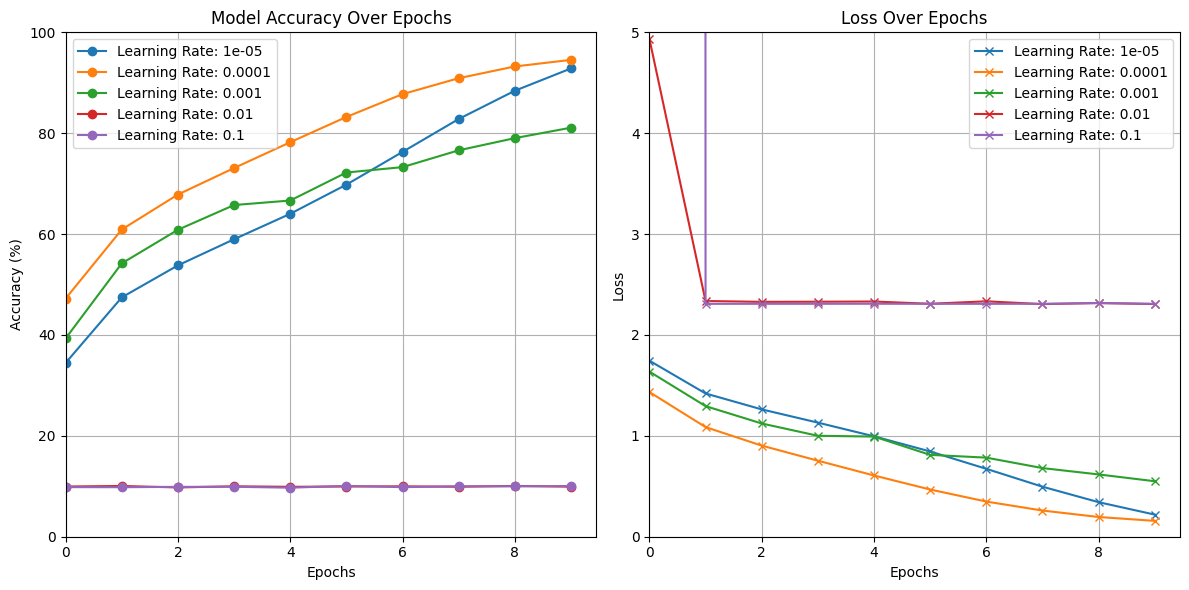

In [102]:
plot_training_accuracy(models_lr, learning_rates, 'Learning Rate')

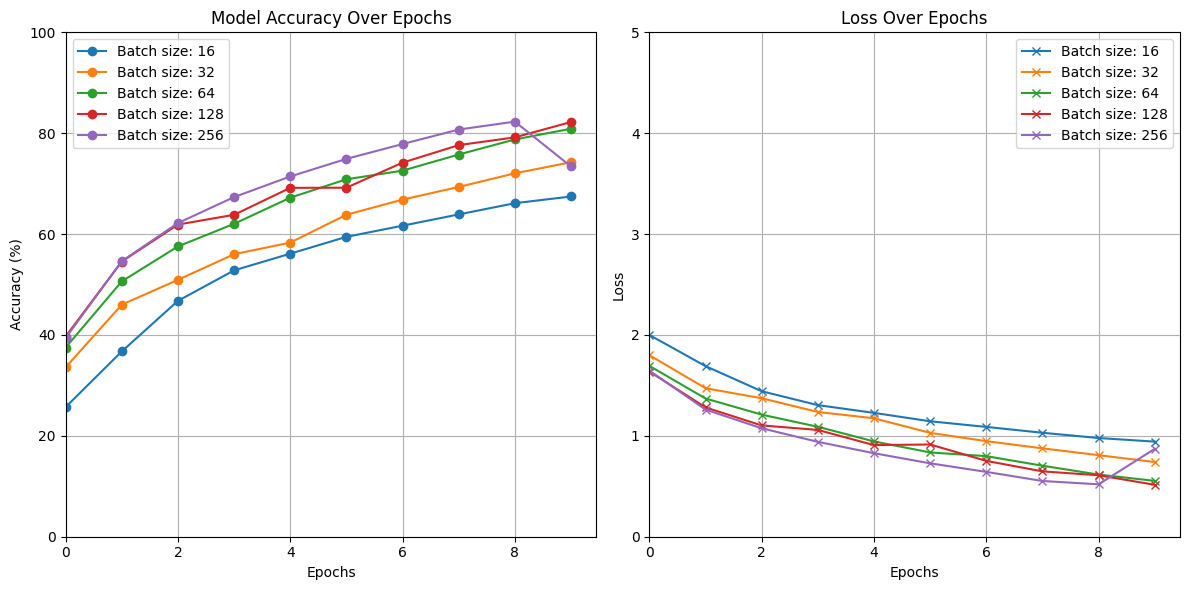

In [103]:
plot_training_accuracy(models_bs, batch_sizes, 'Batch size')

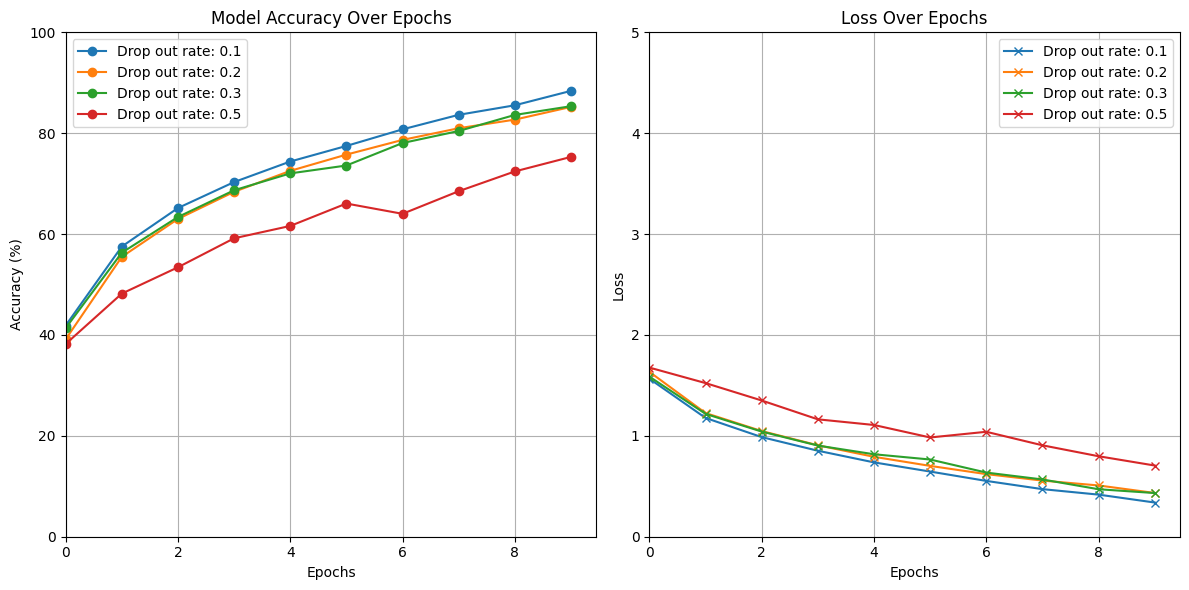

In [104]:
plot_training_accuracy(models_dr, drop_out_rates, 'Drop out rate')

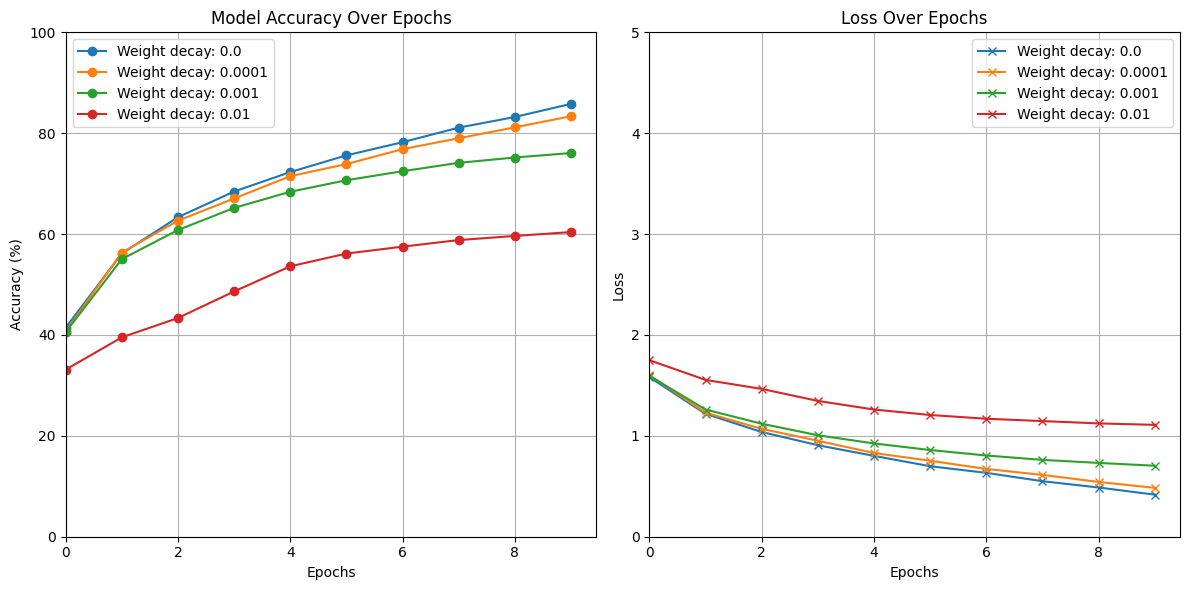

In [105]:
plot_training_accuracy(models_wd, weight_decays, 'Weight decay')

### Visualisation of test results

In [124]:
def plot_accuracy_for_test(metrics, params, measure_name):
    accuracies = [metric['accuracy'] for metric in metrics]

    plt.figure(figsize=(10, 6))

    x_positions = range(len(params)) 

    plt.scatter(x_positions, accuracies, color='blue', marker='o')

    plt.title(f'Accuracy vs. {measure_name} On Validation Dataset')
    plt.xlabel(f'{measure_name}')
    plt.ylabel('Accuracy (%)') 

    plt.xticks(x_positions, params) 
    plt.grid()  

    plt_path = os.path.join('visualisations', f"Test_{measure_name.replace(' ', '_')}.png")
    plt.savefig(plt_path)

    plt.tight_layout()
    plt.show()
    plt.close()

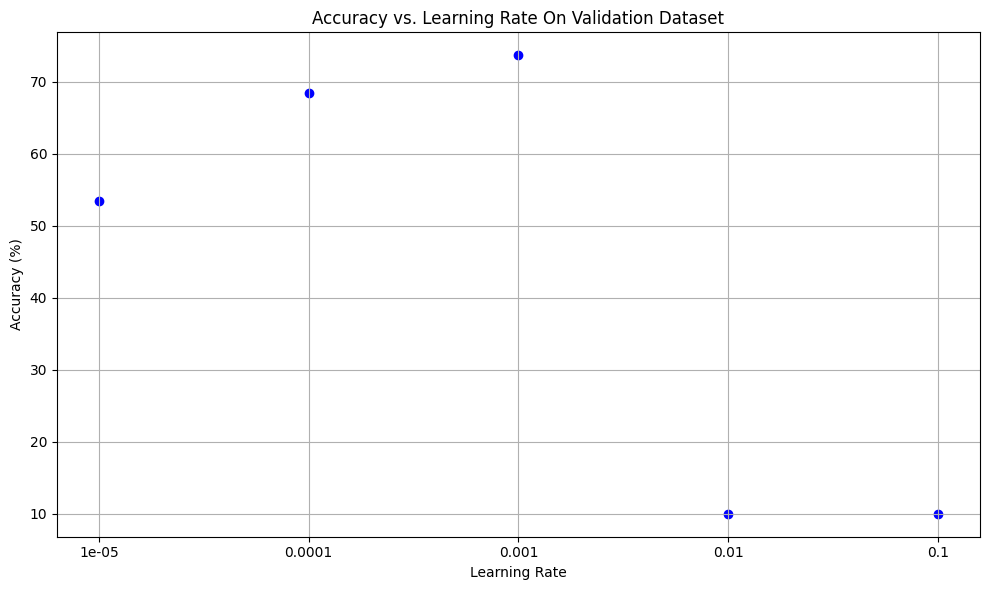

In [120]:
plot_accuracy_for_test(tests_lr, learning_rates, 'Learning Rate')

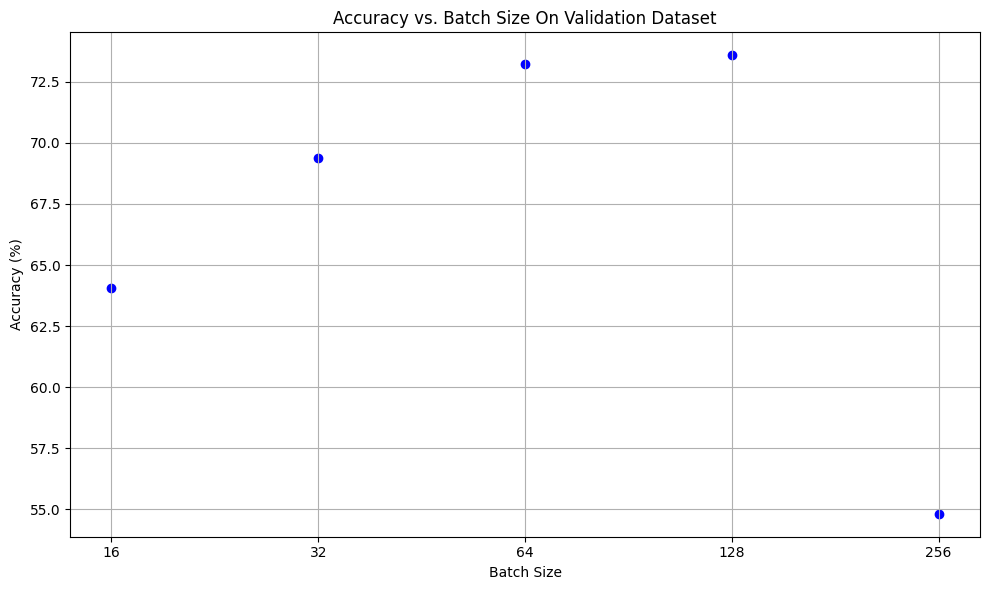

In [121]:
plot_accuracy_for_test(tests_bs, batch_sizes, 'Batch Size')

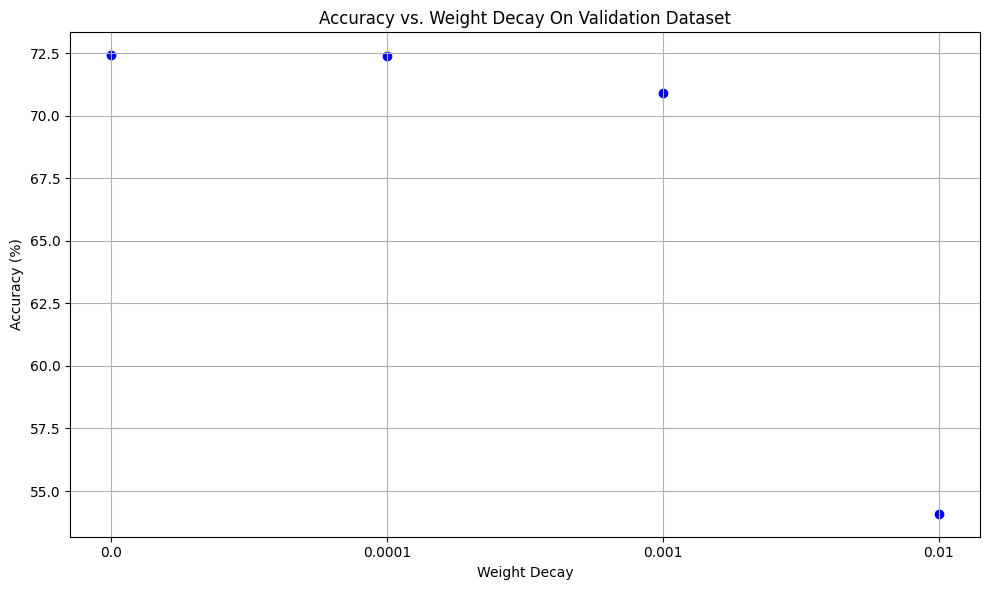

In [122]:
plot_accuracy_for_test(tests_wd, weight_decays, 'Weight Decay')

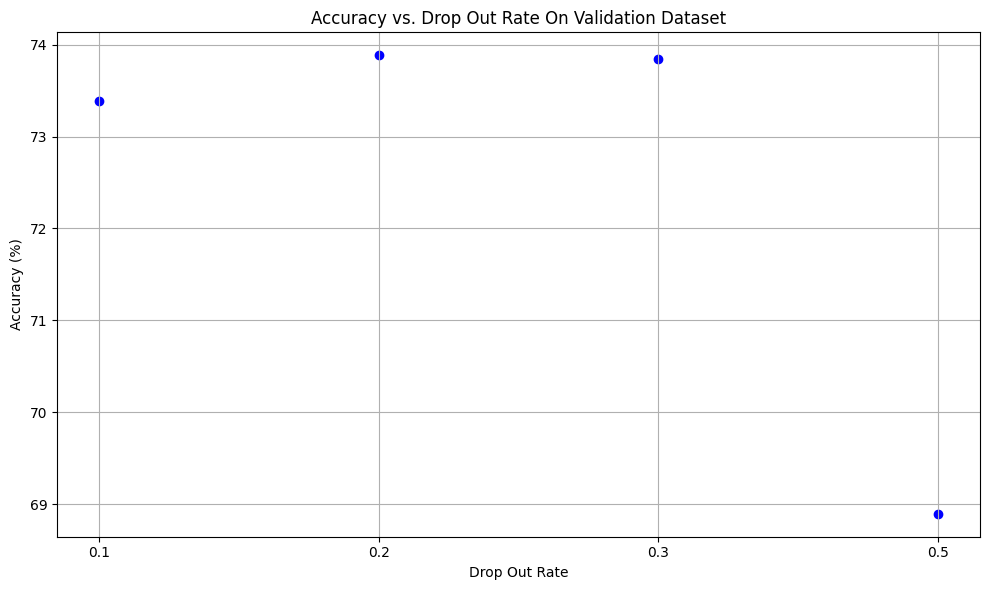

In [123]:
plot_accuracy_for_test(tests_dr, drop_out_rates, 'Drop Out Rate')